In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm

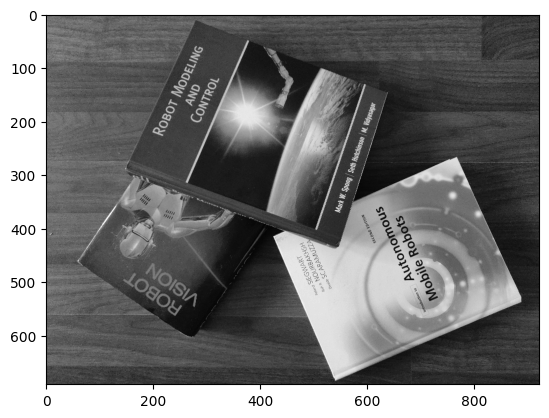

In [2]:
img = cv2.imread('books.png')
# Changing the order from bgr to rgb so that matplotlib can show it
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap=cm.gray)

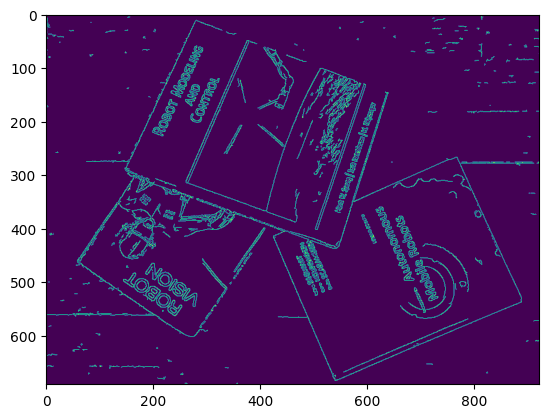

In [3]:
edges = cv2.Canny(gray, 100, 200)
plt.imshow(edges)

In [5]:
threshold=200
theta=0.0017
lines = cv2.HoughLines(edges, 1, theta, threshold) 
print(len(lines))

32


In [12]:
### Insert Harris Corner detector here ###
blockSize=2
ksize=3
k=0.04
dst = cv2.cornerHarris(gray, blockSize, ksize, k)
res = sum(map(lambda i: i > 0.01, dst))

print(np.sum(res))

188


In [22]:
things_1 = cv2.imread('things1.png')
things_2 = cv2.imread('things2.png')
things_1_gray = cv2.cvtColor(things_1, cv2.COLOR_BGR2GRAY)
things_2_gray = cv2.cvtColor(things_2, cv2.COLOR_BGR2GRAY)

maxCorners=100
qualityLevel=0.3
minDistance=7
feat1 = cv2.goodFeaturesToTrack(things_1_gray,maxCorners,qualityLevel,minDistance)

feat2, status, error = cv2.calcOpticalFlowPyrLK(things_1_gray, things_2_gray, feat1, None)
# for i in range(len(feat1)):
#     f10=int(feat1[i][0][0])
#     f11=int(feat1[i][0][1])
#     f20=int(feat2[i][0][0])
#     f21=int(feat2[i][0][1])
#     cv2.line(things_2, (f10,f11), (f20, f21), (0, 255, 0), 2)
#     cv2.circle(things_2, (f10, f11), 5, (0, 255, 0), -1)

# plt.figure(figsize=(15,15))
# plt.imshow(things_2)
dist = []
for i in range(len(feat1)):
    f10=int(feat1[i][0][0])
    f20=int(feat2[i][0][0])

    dist.append(np.abs(f10-f20))
dist = np.array(dist)
print(np.max(dist))
print(len(feat1))
print(len(feat2))

15
27
27


# Stereo Calibration

In [23]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
        
    return img1,img2

FUNDAMENTAL MATRIX
[[-1.02639847e-06 -1.24800968e-04  8.64728611e-02]
 [ 1.28819599e-04  6.74720952e-05 -1.01047600e+00]
 [-8.26782464e-02  9.82754084e-01  1.00000000e+00]]


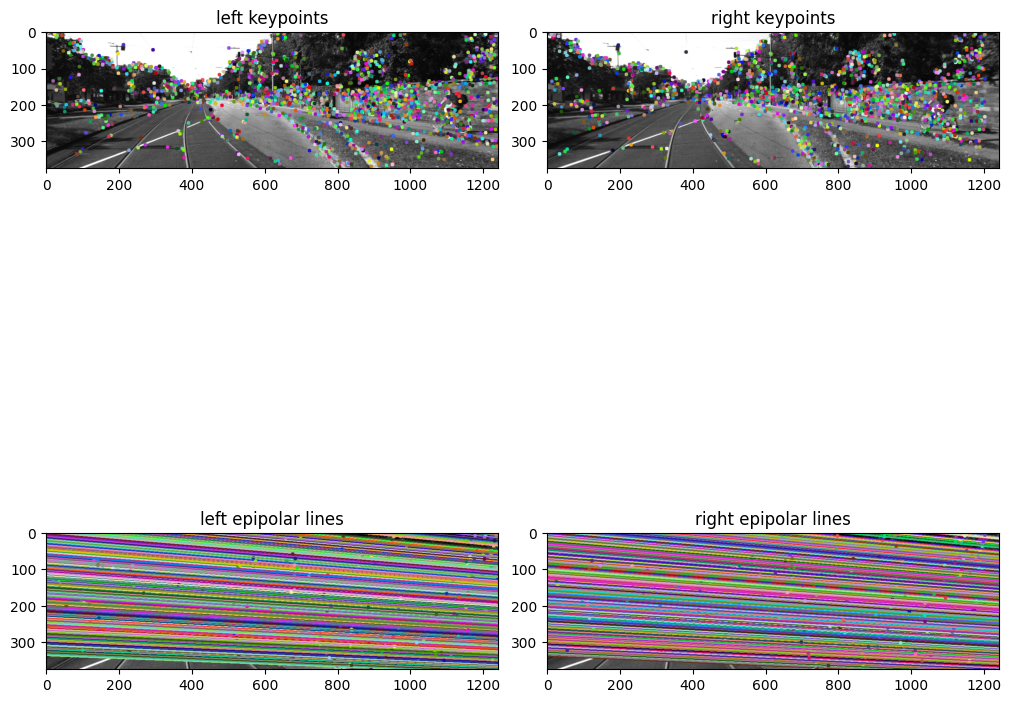

(1577, 3)
[-6.69333264e-02  9.97691572e-01 -1.26727486e+02]
[ 7.0291542e-02 -9.9747336e-01  1.2541019e+02]


In [49]:
dst_left = cv2.imread('left.png',0)
dst_right = cv2.imread('right.png',0)
# dst_left = cv2.cvtColor(dst_left, cv2.COLOR_BGR2GRAY)
# dst_right = cv2.cvtColor(dst_right, cv2.COLOR_BGR2GRAY)
# You should use 2000 of the best matching sift keypoints to compute the epipolar
# lines
# Note: opencv computes the epipolar lines in the form ax+by+c=0.

# DETECT KEYPOINTS: SIFT AND FLANN
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(dst_left, None)
kp2, des2 = sift.detectAndCompute(dst_right, None)

# kp_img = cv2.drawKeypoints(dst_right, kp2, dst_right, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.figure(figsize = (10,10))
# plt.imshow(kp_img)

bf = cv2.BFMatcher()
matches = bf.match(des1, des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

nb_matches = 2000

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)


F, mask = cv2.findFundamentalMat(pts1,pts2)
print("FUNDAMENTAL MATRIX")
print(F)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(dst_left, dst_right, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(dst_right, dst_left, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

# nowget the average of the linea for each axis 
print(lines1.shape)
lines1_avg = np.mean(lines1, axis=0)
print(lines1_avg)

lines2_avg = np.mean(lines2, axis=0)
print(lines2_avg)


# Kalman

In [51]:
def update(x, P, Z, H, R, I):
    ### Insert update function
    y = Z - H @ x
    S = H @ P @ H.T + R
    S_inv = np.linalg.pinv(S)
    K = P @ H.T @ S_inv
    x_new = x + K @ y
    p_new = (I - K @ H) @ P
    return x_new, p_new
    
def predict(x, P, F, u):
    ### insert predict function
    x_new = F @ x + u
    p_new = F @ P @ F.T
    return x_new, p_new

In [50]:
x = np.array([[0],[0],[0],[0]])
# x, xd, y, yd
P = 1000 * np.eye(4)
u = np.array([[0],[0],[0],[0]])
F = np.array([[1,1,0,0],
              [0,1,0,0],
              [0,0,1,1],
              [0,0,0,1]])
H = np.array([[1,0,0,0],[0,0,1,0]])
R = 1 * np.eye(2)
I = np.eye(4)

In [53]:
x = np.array([[3],[0.5],[2],[0.33]])

P = np.array([[5,1,0,0],
              [1,2,0,0],
              [0,0,5,1],
              [0,0,1,2]])
x, P = predict(x, P, F, u)

print(x)
print(P)


[[3.5 ]
 [0.5 ]
 [2.33]
 [0.33]]
[[9 3 0 0]
 [3 2 0 0]
 [0 0 9 3]
 [0 0 3 2]]


In [54]:
x = np.array([[5],[0.5],[7],[0.8]])

P = np.array([[0.2,0,0,0],
              [0.2,0.1,0,0],
              [0,0,0.2,0],
              [0,0,0.2,0.1]])

z = np.array([[4.8], [7.1]])

R = np.array([[0.2, 0.2],[0.2,0.2]])

x, P = update(x, P, z, H, R, I)

print(x)
print(P)


[[4.83333333]
 [0.33333333]
 [7.13333333]
 [0.93333333]]
[[0.06666667 0.         0.06666667 0.        ]
 [0.06666667 0.1        0.06666667 0.        ]
 [0.06666667 0.         0.06666667 0.        ]
 [0.06666667 0.         0.06666667 0.1       ]]
